In [1]:
from scipy.stats import hypergeom, multinomial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py_scripts.multinomial_estimator import (
    TwoParamMultinomialEstimator, ThreeParamMultinomialEstimator
)
from py_scripts.common import QuantitiesOfInterest

def calculate_sizes(second_round, both_rounds, nhs=None):
    """
    Build two dataframes to show how the ci and the expectation grows as a function of the
    second observation and the coincidences in both observations.
    """
    vx, vy = np.meshgrid(second_round, both_rounds)
    vy[vy > vx] = vx[vy > vx]
    ci_range, expected_values = [], []
    first = second_round.max()
    for last, both in zip(vx.ravel(), vy.ravel()):
        b = BearPopulationEstimation(first, last, both, nhs)
        b.run()
        q = QuantitiesOfInterest(b.marginal_n)
        ci_range.append(q.credible_interval_values().size)
        expected_values.append(q.expected_value())
    return [
        pd.DataFrame(
            np.array(data).reshape(vx.shape), index=both_rounds, columns=second_round
        ) for data in (ci_range, expected_values)
    ]

## Single parameter estimation (HyperGeometric)

The expected value is: 173.91066898821956
The MAP is: 110
The CI is: [75, 365]


1.4867195147342979e-06

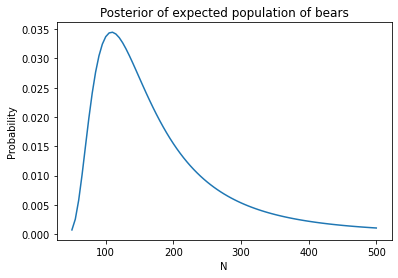

In [2]:
# Work the direct problem pretending we knew the population of bears
# seen first 23, seen second 19, seen same: 4
N, K, k, n = 100, 23, 19, 4
p = hypergeom(N, K, k).pmf(n)

# Create the hypothesis space, likely a range of populations (50, 501)
hs = np.arange(50, 501, 5)
prior = np.ones(hs.size) / hs.size

# Compute the update
likes = hypergeom(hs, K, k).pmf(n)

posterior = prior * likes
posterior = posterior / posterior.sum()
posterior = pd.Series(index=hs, data=posterior)

# plot the distribution
_, ax = plt.subplots()
ax.set_title("Posterior of expected population of bears")
ax.set_xlabel("N")
ax.set_ylabel("Probability")
sns.lineplot(x=hs, y=posterior, ax=ax);

# Also display the most likely value, the expected value and the credible interval 
QuantitiesOfInterest(posterior).run()
from scipy.stats import norm
norm(10, 1).pdf(5)

## Two Parameter Estimation (multinomial)
Estimating Bears With Multinomial Distribution

There are detailed instructions in the docstrings and obsidian, but in a nutshell we can think of our problem as having a 4-side die where the faces are:
* `k10`, the number of bears observed in the first round but not the second,
* `k01`, the number of bears observed in the second round but not the first, and
* `k11`, the number of bears observed in both rounds.
* `k00`, the number of bears never observed

However, we don't know:
- What is the probability of each face
- What is the value of one of the sides `k00`

So we will need to find them

In [3]:
b = BearPopulationEstimation()
b.run()
b.print_quantities()

The expected value is: 138.75027062612662
The MAP is: 94
The CI is: [68, 277]
The expected value is: 0.18365637842135807
The MAP is: 0.157
The CI is: [0.07859999999999999, 0.3236]


## Display How Uncertainty Behaves
### Low observations CI

In [4]:
second_round = np.arange(10, 16)
both_rounds = np.arange(16)
nhs = np.arange(15, 1000)
ci_df, e_df = calculate_sizes(second_round, both_rounds, nhs)
ci_df

,10,11,12,13,14,15
0,799,781,769,765,766,769
1,640,651,665,679,695,711
2,321,343,366,389,413,436
3,133,145,157,171,184,197
4,68,74,81,88,96,104
5,40,44,48,53,58,63
6,25,28,31,34,37,41
7,16,18,21,23,26,28
8,11,13,15,16,18,20
9,7,8,10,11,13,14


### Low Observations Expectation

In [5]:
e_df

,10,11,12,13,14,15
0,434.807519,442.400577,452.097391,463.429613,475.806899,488.624219
1,258.349598,269.996657,282.307997,295.170534,308.407769,321.808105
2,131.555414,141.097407,150.937638,161.063771,171.448496,182.050842
3,73.984002,80.095393,86.436406,93.005122,99.798213,106.810551
4,49.489182,53.651619,57.979657,62.473115,67.131726,71.955099
5,36.999849,40.124768,43.374656,46.749504,50.249300,53.874026
6,29.499999,31.999998,34.599996,37.299994,40.099990,42.999985
7,24.500000,26.583333,28.750000,31.000000,33.333333,35.750000
8,20.928571,22.714286,24.571429,26.500000,28.500000,30.571429
9,18.250000,19.812500,21.437500,23.125000,24.875000,26.687500


### High Observations CI

In [6]:
second_round = np.arange(20, 51, 3)
both_rounds = np.arange(0, 54, 5)
nhs = np.arange(50, 1000)
ci_df, e_df = calculate_sizes(second_round, both_rounds, nhs=nhs)
ci_df


,20,23,26,29,32,35,38,41,44,47,50
0,561,543,526,510,494,478,463,448,433,419,405
5,410,441,471,499,522,543,561,574,583,589,591
10,107,119,130,143,156,169,184,197,213,228,244
15,44,50,55,62,68,74,81,88,95,103,111
20,22,24,28,31,35,39,43,47,51,55,61
25,22,16,14,16,19,21,24,26,30,32,35
30,22,16,13,9,10,12,13,15,17,19,21
35,22,16,13,9,7,5,7,9,9,12,13
40,22,16,13,9,7,5,4,3,4,6,7
45,22,16,13,9,7,5,4,3,2,2,3


### High Observations Expectation

In [7]:
e_df

,20,23,26,29,32,35,38,41,44,47,50
0,719.719215,732.381864,743.743211,753.569494,762.404326,771.006199,779.773770,788.565899,796.965962,804.673976,811.701695
5,295.787754,320.117972,344.822994,369.727537,394.699861,419.651951,444.494593,469.091132,493.258884,516.822209,539.670872
10,133.666606,145.499856,157.832998,170.665914,183.998383,197.830023,212.160195,226.987812,242.311046,258.126937,274.430998
15,85.750000,93.357143,101.285714,109.535714,118.107143,127.000000,136.214286,145.750000,155.607143,165.785714,176.285713
20,63.052632,68.657895,74.500000,80.578947,86.894737,93.447368,100.236842,107.263158,114.526316,122.026316,129.763158
25,63.052632,59.227273,58.875000,63.687500,68.687500,73.875000,79.250000,84.812500,90.562500,96.500000,102.625000
30,63.052632,59.227273,56.500000,54.517857,56.758621,61.051724,65.500000,70.103448,74.862069,79.775862,84.844828
35,63.052632,59.227273,56.500000,54.517857,53.064516,52.000000,55.794118,59.720588,63.779412,67.970588,72.294118
40,63.052632,59.227273,56.500000,54.517857,53.064516,52.000000,51.229730,52.000000,55.538462,59.192308,62.961538
45,63.052632,59.227273,56.500000,54.517857,53.064516,52.000000,51.229730,50.687500,50.325582,52.409091,55.750000


## Lincoln Bug Problem
### Forward problem
Suppose the first tester finds 20 bugs, the second finds 15, and they find 3 in common; how can we estimate the number of bugs?

In [28]:
N = 100
first, last, common = 20, 15, 3
p1, p2 = .2, .15

k11 = common
k10 = first - common
k01 = last - common
k00 = N - k11 - k10 - k01
counts = [k00, k10, k01, k11]

q1 = 1 - p1
q2 = 1 - p2
probs = [q1 * q2, p1 * q1, q1 * p2, p1 * p2]

p = multinomial.pmf(counts, N, probs)

### Inverse problem
We don't know n, p1 and p2

In [1]:
from py_scripts.multinomial_estimator import (
    TwoParamMultinomialEstimator, ThreeParamMultinomialEstimator
)
t = ThreeParamMultinomialEstimator()
t.run()
t.print_quantities()

The expected value is: 105.75020766454246
The MAP is: 72
The CI is: [52, 207]
The expected value is: 0.22971751851795422
The MAP is: 0.1962
The CI is: [0.08839999999999999, 0.4118]
The expected value is: 0.17502287099332803
The MAP is: 0.1374
The CI is: [0.0688, 0.3138]


The expected value is: 105.75020894138075
The MAP is: 72
The CI is: [52, 207]

***********
The expected value is: 0.22971751752869118
The MAP is: 0.1881
The CI is: [0.08909999999999998, 0.4059]

***********
The expected value is: 0.17502287006949335
The MAP is: 0.1386
The CI is: [0.0693, 0.31679999999999997]


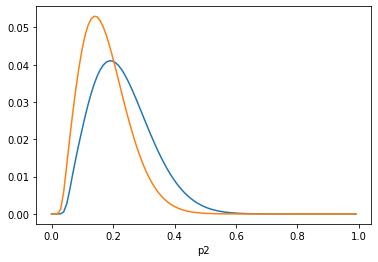

In [46]:
## RUN the inverse problem ##
#############################
# create the hypothesis spaces
ns = np.arange(32, 350, step=5)
p1 = np.linspace(0, .99, 101)
p2 = np.linspace(0, .99, 101)

# Initialise the df that will store all the variables with the hypothesis spaces
n_mesh, p1_mesh, p2_mesh = np.meshgrid(ns, p1, p2)

likes_df = pd.DataFrame({
    "ns": n_mesh.ravel(), "p1": p1_mesh.ravel(), "p2": p2_mesh.ravel()
})

# add counts
fixed_counts_cols = ["k10", "k01", "k11"]
likes_df[fixed_counts_cols] = [first - common, last - common, common]
likes_df["k00"] = likes_df.ns - likes_df[fixed_counts_cols].sum(axis=1)

# Add probs
q1 = 1 - likes_df.p1.values
q2 = 1 - likes_df.p2.values
likes_df["p10"] = likes_df.p1.values * q2
likes_df["p01"] = q1 * likes_df.p2.values
likes_df["p11"] = likes_df.p1.values * likes_df.p2.values
likes_df["p00"] = q1 * q2

# Compute likes
counts = likes_df[["k11", "k10", "k01", "k00"]].values
probs = likes_df[["p11", "p10", "p01", "p00"]].values
likes_df["likes"] = multinomial.pmf(counts, likes_df.ns.values, probs)

# Normalise
likes_df["posterior"] = likes_df.likes / likes_df.likes.sum()

# extract the marginals
marginal_n = likes_df.groupby("ns").posterior.sum()
marginal_p1 = likes_df.groupby("p1").posterior.sum()
marginal_p2 = likes_df.groupby("p2").posterior.sum()
marginal_p1.plot()
marginal_p2.plot()

# compute the quantities of interest
QuantitiesOfInterest(marginal_n).run()
print("\n***********")
QuantitiesOfInterest(marginal_p1).run()
print("\n***********")
QuantitiesOfInterest(marginal_p2).run()